<h3><center>German Credit</center></h3>

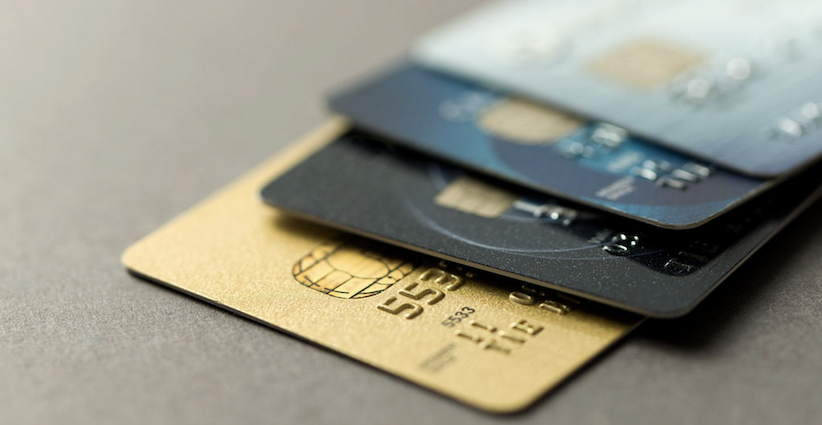

<ol> Column Descriptions :
<li>Status of existing checking account
<li>Duration in month
<li>Credit history
<li>Purpose
<li>Credit amount
<li>Savings account
<li>Present employment since
<li>Installment rate in percentage of disposable income
<li>Personal status and sex
<li>Other debtors
<li>Present residence since
<li>Property
<li>Age in years
<li>Other installment plans
<li>Housing
<li>Number of existing credits at this bank 􏰀 Job
<li>Number of dependents
<li>Telephone
<li>Foreign worker
</ol>

<div style="font-family:verdana; word-spacing:1.5px;">
Some of the categorical variables have an ordinal relationship, such as Savings account, although most do not. There are two outcome classes, 1 for good customers and 2 for bad customers. Good customers are the default or negative class, whereas bad customers are the exception or positive class. A total of 70 percent of the examples are good customers, whereas the remaining 30 percent of examples are bad customers. 
</div>

        Good Customers: Negative or majority class (70%).
        Bad Customers: Positive or minority class (30%).

<div style="font-family:verdana; word-spacing:1.5px;">
A cost matrix is provided with the dataset that gives a different penalty to each misclas- sification error for the positive class. Specifically, a cost of five is applied to a false negative (marking a bad customer as good) and a cost of one is assigned for a false positive (marking a
good customer as bad).
</div>

        Cost for False Negative: 5
        Cost for False Positive: 1

<div style="font-family:verdana; word-spacing:1.5px;">
This suggests that the positive class is the focus of the prediction task and that it is more costly to the bank or financial institution to give money to a bad customer than to not give money to a good customer. This must be taken into account when selecting a performance metric. 
    </div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew 
from scipy import stats
from collections import Counter
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# Importing librarys to use on interactive graphs
import plotly.offline as plty
from plotly import tools
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection

# to set a style to all graphs
plt.style.use('fivethirtyeight')
init_notebook_mode(connected=True)
sns.set_style("whitegrid")
sns.set_context("paper")
%matplotlib inline

<h3><center>1. Reading file</center></h3>

In [2]:
FILE_PATH = '../input/german-credit-history/german.csv'
columns = ['STATUS_CHECKING_ACCOUNT','DURATION_MONTH','CREDIT_HISTORY','PURPOSE','CREDIT_AMOUNT',
           'SAVINGS_ACCOUNT','EMPLOYMENT_SINCE','INSTALLMENT_PERCENTAGE_INCOME',
           'PERSONAL_STATUS_SEX','OTHER_DEBTORS','RESIDENCE_SINCE','PROPERTY','AGE',
           'INSTALLMENT_PLANS','HOUSING','NUMBER_OF_CREDITS','JOB','NUMBER_OF_DEPENDENTS','TELEPHONE','FOREIGN_WORKER','TARGET']

credit_df = pd.read_csv(FILE_PATH, header=None, names=columns)

credit_df.sample(5)

,STATUS_CHECKING_ACCOUNT,DURATION_MONTH,CREDIT_HISTORY,PURPOSE,CREDIT_AMOUNT,SAVINGS_ACCOUNT,EMPLOYMENT_SINCE,INSTALLMENT_PERCENTAGE_INCOME,PERSONAL_STATUS_SEX,OTHER_DEBTORS,...,PROPERTY,AGE,INSTALLMENT_PLANS,HOUSING,NUMBER_OF_CREDITS,JOB,NUMBER_OF_DEPENDENTS,TELEPHONE,FOREIGN_WORKER,TARGET
663,A12,6,A33,A42,1050,A61,A71,4,A93,A101,...,A122,35,A142,A152,2,A174,1,A192,A201,1
822,A11,36,A32,A42,2712,A61,A75,2,A93,A101,...,A122,41,A141,A152,1,A173,2,A191,A201,2
77,A12,11,A33,A43,4771,A61,A74,2,A93,A101,...,A122,51,A143,A152,1,A173,1,A191,A201,1
338,A11,24,A32,A42,4169,A61,A73,4,A93,A101,...,A122,28,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


<h3><center>2. Preprocessing/Cleaning Data</center></h3>

In [3]:
def preprocess_data():
    # Replace Target 
    credit_df_one_hot = credit_df.copy()
    
    # Remove 'A' from categorical columns
    for column in credit_df.select_dtypes(include='object').columns:
        credit_df[column] = credit_df[column].str.replace('A','')
        credit_df_one_hot.drop([column], axis=1, inplace=True)
        
    # One hot encode Categorical columns
    credit_df_one_hot = pd.concat([pd.get_dummies(credit_df.select_dtypes(include='object'), drop_first=True), credit_df_one_hot], axis=1) 
    
    return credit_df, credit_df_one_hot

In [4]:
credit_df, dummy_df = preprocess_data()

encode = LabelEncoder()

encoded = encode.fit_transform(credit_df['TARGET'])

credit_df['TARGET'] = encoded
dummy_df['TARGET'] = encoded

<h3><center>3. Exploring Data</center></h3>

In [5]:
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [6]:
DataDesc(credit_df)

Dataset Shape: (1000, 21)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,STATUS_CHECKING_ACCOUNT,object,0,4,11,12,14,1.80
1,DURATION_MONTH,int64,0,33,6,48,12,3.76
2,CREDIT_HISTORY,object,0,5,34,32,34,1.71
3,PURPOSE,object,0,10,43,43,46,2.67
4,CREDIT_AMOUNT,int64,0,921,1169,5951,2096,9.80
5,SAVINGS_ACCOUNT,object,0,5,65,61,61,1.69
6,EMPLOYMENT_SINCE,object,0,5,75,73,74,2.16
7,INSTALLMENT_PERCENTAGE_INCOME,int64,0,4,4,2,2,1.81
8,PERSONAL_STATUS_SEX,object,0,4,93,92,93,1.53
9,OTHER_DEBTORS,object,0,3,101,101,101,0.54


<h3>3.1. Exploring Different job categories</h3>

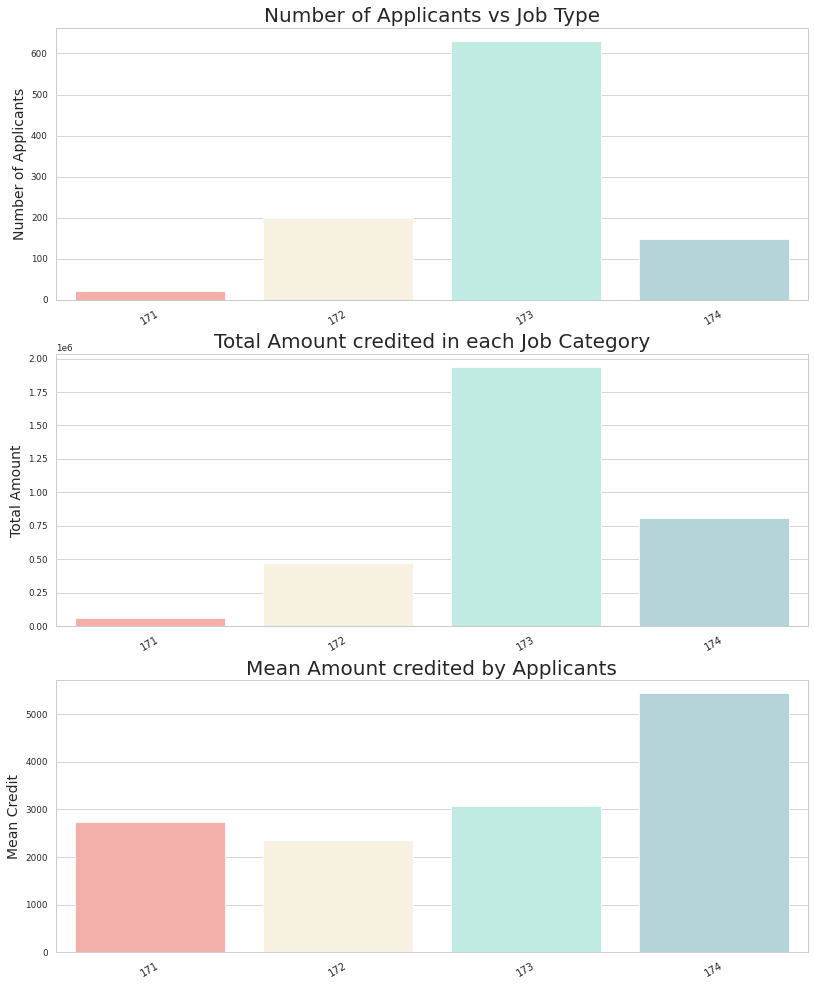

In [7]:
jobs = credit_df.groupby('JOB')['CREDIT_AMOUNT'].agg(['count','sum','mean']).reset_index()

color = ["#ffa69e","#faf3dd","#b8f2e6","#aed9e0","#5e6472",'#f6bd60','#84a59d','#f8edeb']
customPalette = sns.set_palette(sns.color_palette(color))

fig = plt.figure(figsize=(12,17))

ax1 = fig.add_subplot(311)
_ = sns.barplot(data=jobs, x='JOB', y='count', palette= customPalette, ax=ax1)
xlabels = jobs['JOB'].to_list()
ylabels = jobs['count']
_ = ax1.set_title('Number of Applicants vs Job Type', fontsize=20)
_ = ax1.set_ylabel('Number of Applicants', fontsize=14)
_ = ax1.set_xlabel('')
_ = ax1.set_xticklabels(xlabels, rotation=30, fontsize=10)

ax2 = fig.add_subplot(312)
_ = sns.barplot(data=jobs, x='JOB', y='sum', palette= customPalette, ax=ax2)
xlabels = jobs['JOB'].to_list()
ylabels = jobs['sum']
_ = ax2.set_title('Total Amount credited in each Job Category', fontsize=20)
_ = ax2.set_ylabel('Total Amount', fontsize=14)
_ = ax2.set_xlabel('')
_ = ax2.set_xticklabels(xlabels, rotation=30, fontsize=10)

ax3 = fig.add_subplot(313)
_ = sns.barplot(data=jobs, x='JOB', y='mean', palette= customPalette, ax=ax3)
xlabels = jobs['JOB'].to_list()
ylabels = jobs['mean']
_ = ax3.set_title('Mean Amount credited by Applicants', fontsize=20)
_ = ax3.set_ylabel('Mean Credit', fontsize=14)
_ = ax3.set_xlabel('')
_ = ax3.set_xticklabels(xlabels, rotation=30, fontsize=10)

<blockquote>No.of Applicaant having Job type-174 are second least but have creditted the highest mean amount. This category reflects the highest paying one</blockquote>

In [8]:
job_target = credit_df.groupby(['JOB','TARGET']).size().rename('COUNT').reset_index()



fig  = px.histogram(job_target, 
              x='JOB', 
              y='COUNT',
              color='TARGET',
              color_discrete_sequence=["#457b9d","#fca311"],
              template='plotly_white')

fig.update_layout(width=900, height=400, 
                  barmode='group',
                  title= {'text': "Job Category vs Good/Bad Customer",
                          'y':0.95,'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                 showlegend=True,
                 margin = dict(l=25, r=10, t=50, b=10))
                 
                 
fig.show()

In [9]:
sum_job = job_target.groupby(['JOB']).sum().reset_index()


def ratio(columns):
    JOB, TARGET, COUNT = columns[0], columns[1], columns[2]
    TOTAL = sum_job[sum_job['JOB'] == JOB]['COUNT']
    RATIO = np.round(COUNT/TOTAL, 2)
    return RATIO

X = job_target[['JOB','TARGET','COUNT']].apply(ratio, axis=1)
job_target['RATIO'] = X.sum(axis=1)

In [10]:
fig  = px.histogram(job_target, 
              x='JOB', 
              y='RATIO',
              color='TARGET',
              color_discrete_sequence=["#457b9d","#fca311"],
              template='plotly_white')

fig.update_layout(width=900, height=400, 
                  barmode='group',
                  title= {'text': "Job Category vs Good/Bad Customer RATIO",
                          'y':0.95,'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                 showlegend=True,
                 margin = dict(l=25, r=10, t=50, b=10))
                 
                 
fig.show()

<blockquote>Ratio of Good & Bad customers in each category is somewhat same, hence we cannot easily identify the category in which chances of being a bad customer is the highest</blockquote>

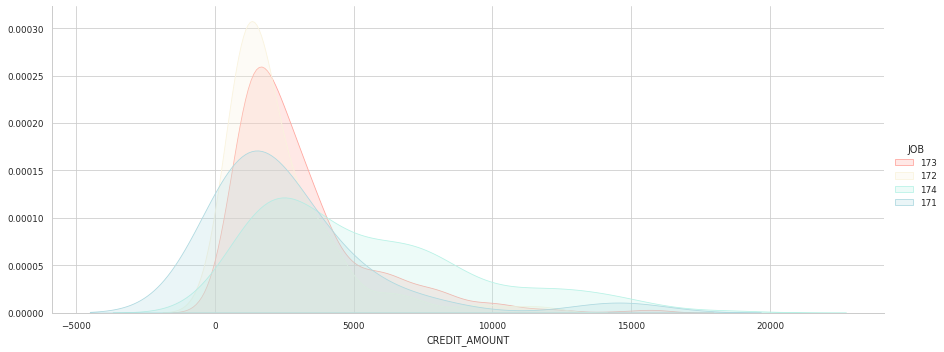

In [11]:
_ = sns.FacetGrid(credit_df[['JOB','CREDIT_AMOUNT']],
               hue='JOB', height=5, aspect=2.5)\
  .map(sns.kdeplot, 'CREDIT_AMOUNT', shade=True)\
 .add_legend()

<blockquote>The distribution of Credit amount shows a right skew</blockquote>

<h3>3.2. Exploring Age </h3>

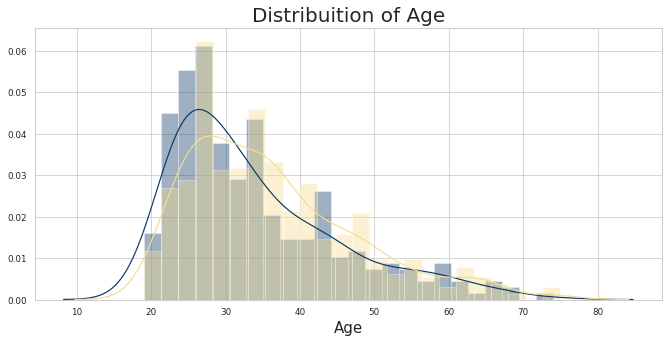

In [12]:
age_bad = credit_df.query("TARGET == 1")['AGE']
age_good = credit_df.query("TARGET == 0")['AGE']

#figure size
plt.figure(figsize=(10,5))

# Ploting the 2 variables that we create and compare the two
sns.distplot(age_bad, bins=24, color='#0d3b66')
sns.distplot(age_good, bins=24, color='#f5dd90')
plt.title("Distribuition of Age",fontsize=20)
plt.xlabel("Age",fontsize=15)
plt.ylabel("")
plt.show()

<blockquote>Distrubition of age in both Good and Bad categories is the same</blockquote>

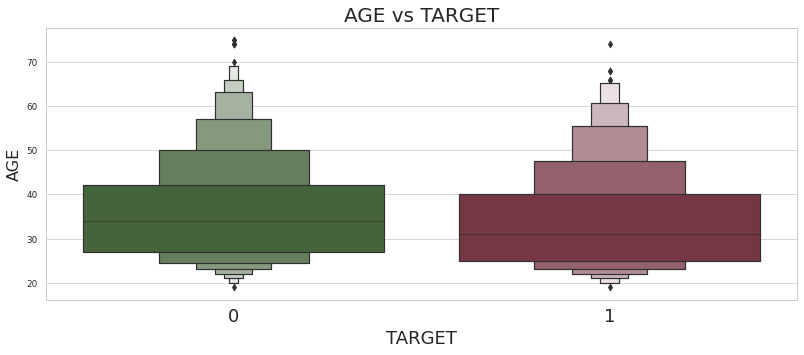

In [13]:
_ = plt.figure(figsize=(12,5))

_ = sns.boxenplot(x="TARGET", y = "AGE", 
              data=credit_df, palette=['#436a36','#802c3e']) 
_ = plt.title("AGE vs TARGET", fontsize=20) 
_ = plt.xlabel("TARGET", fontsize=18) 
_ = plt.ylabel("AGE", fontsize=16) 
_ = plt.xticks(fontsize=18)

<h3> Categorizing Age</h3>

In [14]:
interval = (0, 20, 30, 40, 50, 60) 

#Seting the names that we want use to the categorys
categories = ['TEEN_AGE', 'ADULT', 'MID_AGED','SENIOR_50', 'SENIOR_60']

credit_df["AGE_CAT"] = pd.cut(credit_df.AGE, interval, labels=categories) 

In [15]:
group = credit_df.groupby(['AGE_CAT','TARGET']).size().rename('Count').reset_index()

fig  = px.histogram(group, 
              x='AGE_CAT', 
              y='Count',
              color='TARGET',
              color_discrete_sequence=["#457b9d","#fca311"],
              template='plotly_white')

fig.update_layout(width=900, height=400, 
                  barmode='group',
                  title= {'text': "AGE group Good vs Bad",
                          'y':0.95,'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                 showlegend=True,
                 margin = dict(l=25, r=10, t=50, b=10))
                 
                 
fig.show()

In [16]:
total_age = group.groupby('AGE_CAT')['Count'].sum().reset_index()
def ratio(columns):
    AGE_CAT, Count = columns[0], columns[1]
    TOTAL = total_age[total_age['AGE_CAT'] == AGE_CAT]['Count']
    RATIO = Count/TOTAL
    
    return np.round(RATIO, 2)

group['RATIO'] = np.sum(group[['AGE_CAT','Count']].apply(ratio, axis=1), axis=1)

In [17]:
fig  = px.histogram(group, 
              x='AGE_CAT', 
              y='RATIO',
              color='TARGET',
              color_discrete_sequence=["#457b9d","#fca311"],
              template='plotly_white')

fig.update_layout(width=900, height=400, 
                  barmode='group',
                  title= {'text': "AGE Category vs Good/Bad Customer RATIO",
                          'y':0.95,'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                 showlegend=True,
                 margin = dict(l=25, r=10, t=50, b=10))
                 
                 
fig.show()

<blockquote>Customers in their 20s & 30s seem to have a bad review from the bank and the ones in their 40s & 50s have a godd relationship with the bank</blockquote>

In [18]:
group = credit_df.groupby(['AGE_CAT','NUMBER_OF_DEPENDENTS']).size().rename('Count').reset_index()
total_dependents = group.groupby('AGE_CAT')['Count'].sum().reset_index()

display(group)
print('Total Dependents')
display(total_dependents)

,AGE_CAT,NUMBER_OF_DEPENDENTS,Count
0,TEEN_AGE,1,15
1,TEEN_AGE,2,1
2,ADULT,1,376
3,ADULT,2,19
4,MID_AGED,1,240
5,MID_AGED,2,75
6,SENIOR_50,1,112
7,SENIOR_50,2,49
8,SENIOR_60,1,60
9,SENIOR_60,2,8


Total Dependents


,AGE_CAT,Count
0,TEEN_AGE,16
1,ADULT,395
2,MID_AGED,315
3,SENIOR_50,161
4,SENIOR_60,68


In [19]:
import plotly.graph_objs as go

labels = ['TEEN_AGE', 'ADULT', 'MID_AGED', 'SENIOR_50', 'SENIOR_60']
outer_values = [16, 395, 315, 161, 68]
inner_values = [15, 1, 376, 19, 240, 75, 112, 49, 60, 8]


trace1 = go.Pie(
    hole=0.5,
    sort=False,
    direction='clockwise',
    labels=['T_1','T_2','A_1','A_2','M_1','M_2','S_50_1','S_50_2','S_60_1','S_60_2'],
    domain={'x': [0.15, 0.85], 'y': [0.15, 0.85]},
    values=inner_values,
    textinfo='label',
    textposition='inside',
    marker={'line': {'color': 'white', 'width': 1}}
)

trace2 = go.Pie(
    hole=0.7,
    sort=False,
    direction='clockwise',
    values=outer_values,
    labels=labels,
    textinfo='label',
    textposition='outside',
    marker={'colors': ['green', 'red', 'blue', 'brown'],
            'line': {'color': 'white', 'width': 1}}
)

fig = go.FigureWidget(data=[trace1, trace2])
iplot(fig)

<blockquote>From Above we can see how most of the customers have only 1 dependents. Also majority of the customers are between age group 20 to 40</blockquote>

<h3><center>4. Important Features</center></h3>

<h3>4.1. Feature Importance using Random Forrest Classifier</h3>

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder


rf = RandomForestClassifier()

params = {
                'max_depth' : [1,2,3,4,5,6],
               'min_samples_leaf' : [0.01,0.02,0.04,0.06],
                'max_features' : [0.1,0.2,0.4,0.8],
                'n_estimators' : [100,150,200,250,300]
                
        }

rf_cv = RandomizedSearchCV(estimator=rf,
                          param_distributions=params,
                           n_iter=100,
                          cv=10,
                          scoring='accuracy',
                          n_jobs=-1,
                           verbose=3
                          )
X = credit_df.drop(['TARGET','AGE_CAT'], axis=1)
y = credit_df['TARGET']


# Training
rf_cv.fit(X, y)


#Best Estimator
rf_best = rf_cv.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished


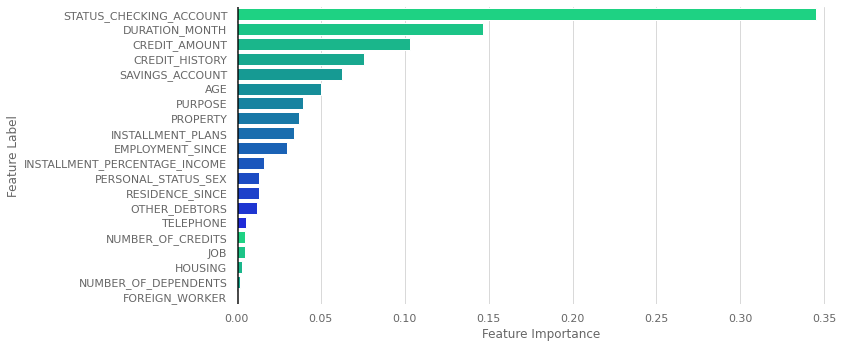

In [21]:
# Get feature importance
selected_features = X.columns.to_list()
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = rf_best.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('winter', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("feature_importance.png", dpi = 1080)

Features that have great impact on TARGET:
<ol>
<li>Status of existing checking account
<li>Duration Month
<li>Credit Amount
<li>Credit History
<li>Savings Account
<li>Age
    </ol>

<h3>4.2. Permutation Importance</h3>

In [22]:
import eli5 
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_best, random_state=105).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.to_list())

Weight,Feature
0.0690 ± 0.0084,STATUS_CHECKING_ACCOUNT
0.0574 ± 0.0202,DURATION_MONTH
0.0348 ± 0.0062,SAVINGS_ACCOUNT
0.0296 ± 0.0145,CREDIT_HISTORY
0.0286 ± 0.0106,CREDIT_AMOUNT
0.0120 ± 0.0077,PURPOSE
0.0086 ± 0.0030,PROPERTY
0.0038 ± 0.0034,INSTALLMENT_PERCENTAGE_INCOME
0.0038 ± 0.0039,PERSONAL_STATUS_SEX
0.0032 ± 0.0039,AGE


<h3>4.3. Shap Analysis</h3>

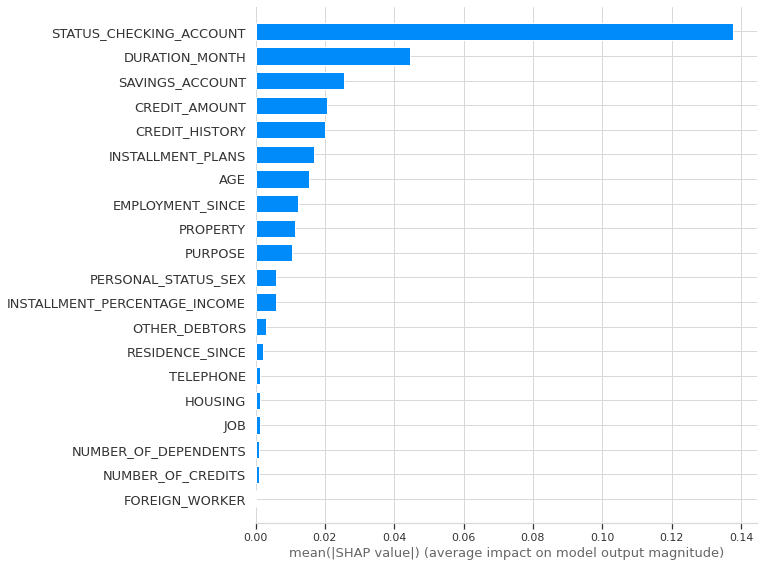

In [23]:
import shap 

explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[1], X, plot_type="bar")

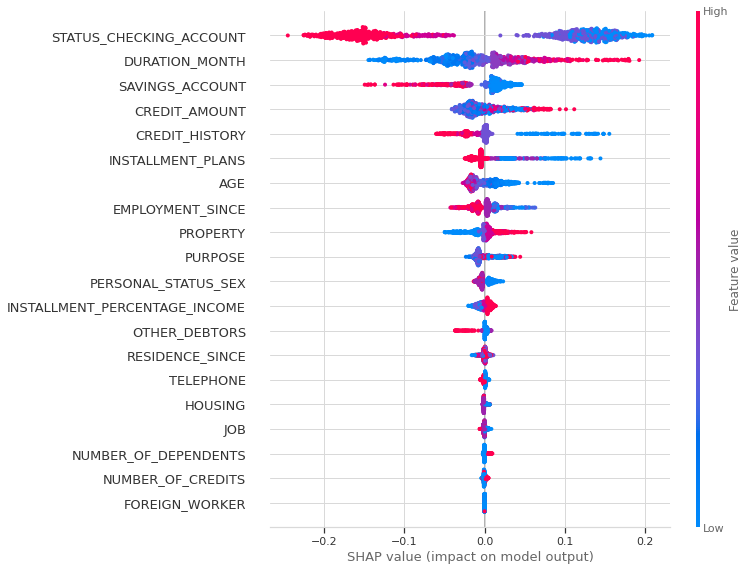

In [24]:
shap.summary_plot(shap_values[1], X)

Features with High values(Red) that lead to a Bad Customer record(If low value then Good):
<ol>
    <li>Duration in Month
    <li>Credit Amount
</ol>
Features with Low values(Blue) that lead to a Bad Customer Record
<ol>
    <li>Status of existing checking account
        <li>Savings Account
            <li>Credit History
                <li>Age
    </ol>
Above observations are true to real life instances in Banking System

In [25]:
dummy_df.head()

,STATUS_CHECKING_ACCOUNT_12,STATUS_CHECKING_ACCOUNT_13,STATUS_CHECKING_ACCOUNT_14,CREDIT_HISTORY_31,CREDIT_HISTORY_32,CREDIT_HISTORY_33,CREDIT_HISTORY_34,PURPOSE_41,PURPOSE_410,PURPOSE_42,...,TELEPHONE_192,FOREIGN_WORKER_202,DURATION_MONTH,CREDIT_AMOUNT,INSTALLMENT_PERCENTAGE_INCOME,RESIDENCE_SINCE,AGE,NUMBER_OF_CREDITS,NUMBER_OF_DEPENDENTS,TARGET
0,0,0,0,0,0,0,1,0,0,0,...,1,0,6,1169,4,4,67,2,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,48,5951,2,2,22,1,1,1
2,0,0,1,0,0,0,1,0,0,0,...,0,0,12,2096,2,3,49,1,2,0
3,0,0,0,0,1,0,0,0,0,1,...,0,0,42,7882,2,4,45,1,2,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,24,4870,3,4,53,2,2,1


<h3><center>5. Model test & Baseline Result</center></h3>
<div style="font-family:verdana; word-spacing:1.5px;">
    We will predict class labels of whether a customer is good or not. Therefore, we need a measure that is appropriate for evaluating the predicted class labels. The focus of the task is on the positive class (bad customers). Precision and recall are a good place to start. Maximizing precision will minimize the false positives and maximizing recall will minimize the false negatives in the predictions made by a model.
    <br><br>
    False positives are cases of a good customer being marked as a bad customer and not being given a loan. False negatives are more costly to the bank than false positives.<br><br>
    <blockquote>Cost(FalseNegatives) > Cost(FalsePositives) </blockquote>
Put another way, we are interested in the F-measure that will summarize a model’s ability to minimize misclassification errors for the positive class, but we want to favor models that are better are minimizing false negatives over false positives. This can be achieved by using a version of the F-measure that calculates a weighted harmonic mean of precision and recall but favors higher recall scores over precision scores. This is called the Fbeta-measure, a generalization of F-measure, where beta is a parameter that defines the weighting of the two scores. A beta value of 2 will weight more attention on recall than precision and is referred to as the F2-measure.
    </div>
    
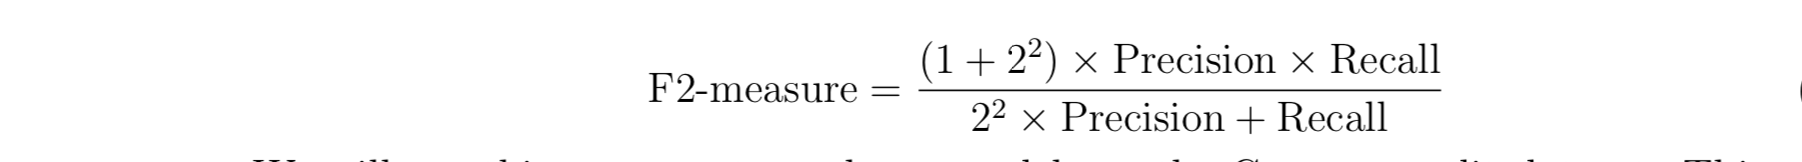

<div style="font-family:verdana; word-spacing:1.5px;">
We can evaluate a baseline model on the dataset using this test harness. A model that predicts the minority class for examples will achieve a maximum recall score and a baseline precision score. The F2-measure from this prediction provides a baseline in model performance on this problem by which all other models can be compared. This can be achieved using the DummyClassifier class from the scikit-learn library and setting the strategy argument to ‘constant’ and the constant argument to 1 for the minority class.
  </div>

In [26]:
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    metric = make_scorer(f2_measure)
    
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [27]:
X = dummy_df.drop('TARGET', axis=1)
y = dummy_df['TARGET']

model = DummyClassifier(strategy='constant', constant=1)


scores = evaluate_model(X, y, model)

print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Mean F2: 0.682 (0.000)


<h3><center>6. Evaluate Machine Learning Algorithms</center></h3>

In [28]:
def get_models():
    models, names = list(), list()
    # LR 
    models.append(LogisticRegression(solver='liblinear')) 
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis()) 
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # GPC
    models.append(GaussianProcessClassifier()) 
    names.append('GPC')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

In [29]:
models, names = get_models()

results = list()


for i in range(len(models)):
    
    pipeline = Pipeline(steps=[('MinMax',MinMaxScaler()),('m',models[i])])
    
    scores = evaluate_model(X, y, pipeline)
    
    results.append(scores)

    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores))) 

>LR 0.500 (0.076)
>LDA 0.519 (0.072)
>NB 0.611 (0.051)
>GPC 0.192 (0.081)
>SVM 0.418 (0.075)


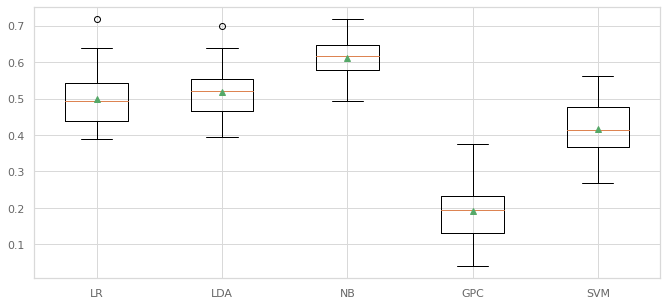

In [30]:
plt.figure(figsize=(10,5))
_ = plt.boxplot(results, labels=names, showmeans=True) 
_ = plt.show()

In this case, we can see that none of the tested models have an F2-measure above the default of predicting the majority class in all cases (0.682). None of the models are skillful. This is surprising, although suggests that perhaps the decision boundary between the two classes is noisy.

<h3><center>7. Evaluating Undersampling</center></h3>
<div style="font-family:verdana; word-spacing:1.5px;">
Undersampling is perhaps the least widely used technique when addressing an imbalanced classification task as most of the focus is put on oversampling the majority class with SMOTE. Undersampling can help to remove examples from the majority class along the decision boundary that make the problem challenging for classification algorithms. In this experiment we will test the following undersampling algorithms:
    <br><br>
    <ul>
    <li>Tomek Links (TL)
    <li>Edited Nearest Neighbors (ENN)
    <li>Repeated Edited Nearest Neighbors (RENN)
    <li>One Sided Selection (OSS)
    <li>Neighborhood Cleaning Rule (NCR)
    </ul><br>
The Tomek Links and ENN methods select examples from the majority class to delete, whereas OSS and NCR both select examples to keep and examples to delete. We will use the cost-sensitive version of the logistic regression algorithm to test each undersampling method in an effort to further lift model performance
</div>

In [31]:
def get_models():
    models, names = list(), list()
    
    models.append(TomekLinks())
    names.append('TL')
    
    models.append(EditedNearestNeighbours()) 
    names.append('ENN')
     
    models.append(RepeatedEditedNearestNeighbours()) 
    names.append('RENN')
    
    models.append(OneSidedSelection()) 
    names.append('OSS')
    
    models.append(NeighbourhoodCleaningRule()) 
    names.append('NCR')
    
    return models, names

In [32]:
models, names = get_models()
results = list()


for i in range(len(models)):
    
    model = LogisticRegression(solver='liblinear', class_weight='balanced')
    
    scaler = MinMaxScaler()
    X_trans = scaler.fit_transform(X)
    
    X_s, y_s = models[i].fit_resample(X_trans, y)
    
    scores = evaluate_model(X_s, y_s, model)
    
    results.append(scores)
    
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>TL 0.679 (0.060)
>ENN 0.806 (0.039)
>RENN 0.850 (0.039)
>OSS 0.682 (0.052)
>NCR 0.781 (0.063)


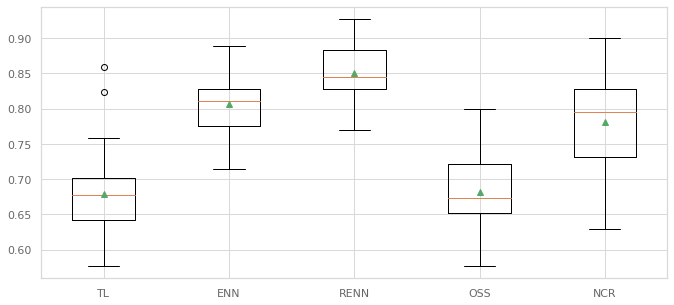

In [33]:
plt.figure(figsize=(10,5))
_ = plt.boxplot(results, labels=names, showmeans=True) 
_ = plt.show()

<h3><center>8. Fitting Final Model</center></h3>

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

powert = PowerTransformer()
scaler = MinMaxScaler()
under_sample = RepeatedEditedNearestNeighbours()

X_scale = scaler.fit_transform(X)
#X_t = powert.fit_transform(X_scale)
X_s, y_s = under_sample.fit_resample(X_scale, y)

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.1, stratify=y_s, random_state=1)


model = LogisticRegression(solver='liblinear', class_weight='balanced')


c_values = [10000, 1000, 800, 500, 100, 10, 1.0, 0.1, 0.01, 0.001]
grid = dict(C=c_values)

metric = make_scorer(f2_measure)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring=metric,error_score=0)

grid_result = grid_search.fit(X_s, y_s)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.855175 using {'C': 10}


<h3><center>9. Evaluating Model</center></h3>

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = grid_result.best_estimator_

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[19  5]
 [ 3 27]]
              precision    recall  f1-score   support

           0       0.86      0.79      0.83        24
           1       0.84      0.90      0.87        30

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54



As we can see, we have tried to maximize the Recall to 90%, having False Negative rates very low

<h3>9.1 RoC AUC</h3>

In [36]:
from sklearn.metrics import roc_curve

y_pred_proba = best_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.782099, G-mean=0.891


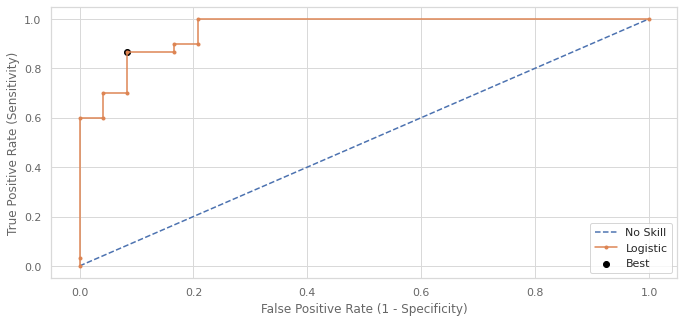

In [37]:
plt.figure(figsize=(10,5))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill') 

plt.plot(fpr, tpr, marker='.', label='Logistic') 
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best') 
# axis labels
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
# show the plot
plt.show()

<h3>9.2. Precision Recall Curve</h3>


In [38]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#Calculate f-Score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest g-mean
ix = np.argmax(fscore)

print('Best Threshold=%f, F-score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.308903, F-score=0.923


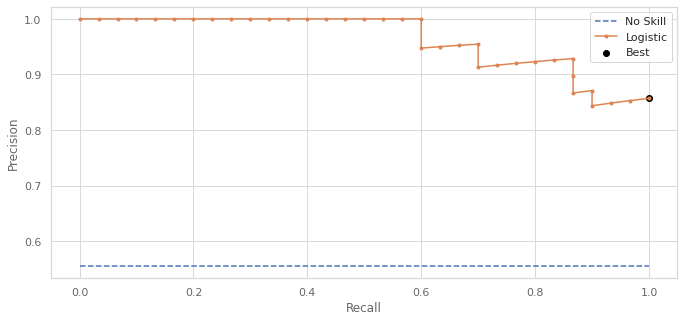

In [39]:
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(10,5))
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
plt.plot(recall, precision, marker='.', label='Logistic') 
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') 
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [40]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [41]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['-VE','+VE']

Normalized confusion matrix
[[0.79 0.21]
 [0.1  0.9 ]]


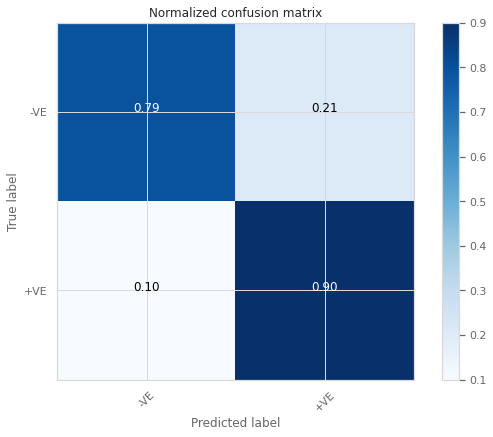

In [42]:
np.set_printoptions(precision=2)


plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')